In [1]:


# -------------------------------
# Stage 1: Business Analyst Task
# -------------------------------
# Business Question: What are the top 5 products by revenue in the last quarter, and how does customer sentiment vary for these products?
# Required data points: product_id, sale_price, quantity, sale_date, customer_id, sentiment_score

# -------------------------------
# Stage 2: Data Engineer Task
# -------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure directory structure
os.makedirs("data_warehouse", exist_ok=True)

# -------------------------------
# Stage 1: Business Analyst Task
# -------------------------------
# Business Question: What are the top 5 products by revenue in the last quarter, 
# and how does customer sentiment vary for these products?
# Required data points: product_id, sale_price, quantity, sale_date, customer_id, sentiment_score

# -------------------------------
# Stage 2: Data Engineer Task
# -------------------------------

# 1. Ingestion
sales_df = pd.read_csv("./raw_data/sale_price.csv")
feedback_df = pd.read_json("./raw_data/customer_feedback.json")

# 2. Cleansing

# Remove '$' and convert sale_price to float
sales_df['sale_price'] = sales_df['sale_price'].replace('[\$,]', '', regex=True).astype(float)

# Fill missing quantity with 1 (default)
sales_df['quantity'] = sales_df['quantity'].fillna(1).astype(int)

# Standardize date format
sales_df['sale_date'] = pd.to_datetime(sales_df['sale_date'], format='mixed', errors='coerce')
feedback_df['review_date'] = pd.to_datetime(feedback_df['review_date'], format='mixed', errors='coerce')

# 3. Transformation

# Compute total revenue
sales_df['total_revenue'] = sales_df['sale_price'] * sales_df['quantity']

# Keep the latest feedback entry per (product_id, customer_id)
feedback_df = feedback_df.sort_values('review_date').drop_duplicates(
    subset=['product_id', 'customer_id'], keep='last'
)

# Merge sales and feedback
merged_df = pd.merge(sales_df, feedback_df, on=['product_id', 'customer_id'], how='left')

# Remove rows where sale_price is 0 or review_date is missing
merged_df = merged_df[(merged_df['sale_price'] > 0) & (merged_df['review_date'].notna())]

# 4. Loading to warehouse
processed_path = "data_warehouse/processed_sales_data.csv"
merged_df.to_csv(processed_path, index=False)

print(f"Processed data saved to {processed_path}")










C:\Users\varda\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Processed data saved to data_warehouse/processed_sales_data.csv


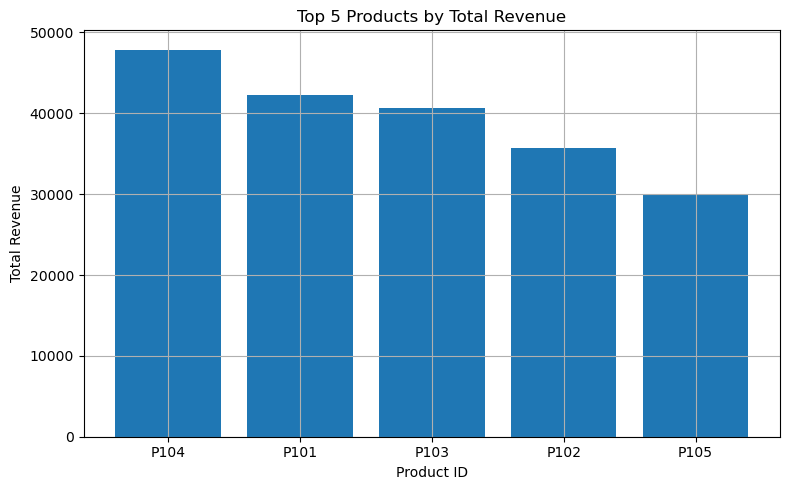

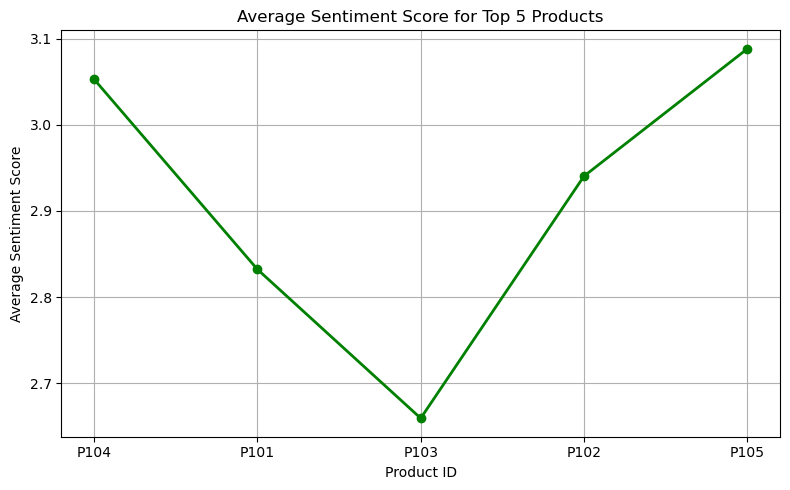


--- Feedback to Data Engineer ---

--- Final Report ---
  product_id  total_revenue  avg_sentiment
0       P104        47872.5       3.052817
1       P101        42313.5       2.832203
2       P103        40714.5       2.659375
3       P102        35674.5       2.940367
4       P105        29949.0       3.088119


In [3]:
# -------------------------------
#  Data Analyst Task
# -------------------------------

import pandas as pd
import matplotlib.pyplot as plt

processed_path = "data_warehouse/processed_sales_data.csv"

# 1. Access processed data
df = pd.read_csv(processed_path)

# 2. Analyse: top 5 products by revenue
top_products = (
    df.groupby('product_id')['total_revenue']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

# Merge to get average sentiment
avg_sentiment = (
    df.groupby('product_id')['sentiment_score']
    .mean()
    .reset_index()
    .rename(columns={'sentiment_score': 'avg_sentiment'})
)

# Merge for final report
report_df = pd.merge(top_products, avg_sentiment, on='product_id', how='left')

# 3. Communicate: Display chart
# 3. Communicate: Display separate charts

# Plot 1: Bar chart for Total Revenue
plt.figure(figsize=(8, 5))
plt.bar(report_df['product_id'], report_df['total_revenue'])
plt.title('Top 5 Products by Total Revenue')
plt.xlabel('Product ID')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Line plot for Average Sentiment Score
plt.figure(figsize=(8, 5))
plt.plot(report_df['product_id'], report_df['avg_sentiment'], color='green', marker='o', linewidth=2)
plt.title('Average Sentiment Score for Top 5 Products')
plt.xlabel('Product ID')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()


# 4. Feedback
print("\n--- Feedback to Data Engineer ---")
if df['sentiment_score'].isnull().sum() > 0:
    print("Some sentiment scores are missing. Consider collecting more feedback data.")
if df['sale_date'].isnull().sum() > 0:
    print("Some sale_date entries couldn't be parsed. Please ensure date consistency.")

print("\n--- Final Report ---")
print(report_df)






